## Problem

**Task [[kaggle](https://www.kaggle.com/c/reface-fake-detection)]:** recognize fake videos. You need to train the binary classifier to distinguish real videos from fake ones (the provided fake data is the result of the technologies developed in Reface).

****

### What I should get?

In order to complete this stage, you should meet one of 2 conditions below:
+ either make a solution with a minimum target metric value of 0.92475
+ or be in the top 30 of all competitors.

****

### Evaluation

The evaluation metric for this competition is F1-Score, average='micro'. The F1 score, commonly used in information retrieval, measures accuracy using the statistics precision p and recall r. Precision is the ratio of true positives (tp) to all predicted positives (tp + fp). Recall is the ratio of true positives to all actual positives (tp + fn).

The F1 metric weights recall and precision equally, and a good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other.

More information you can find at sklearn docs:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

****

### Submission

For each filename in the test set, you must predict either this file is fake video (label 1) or this file is real video (label 0). The file should contain a header and have the following format:

```
filename,label
004582.mp4,1
003603.mp4,0
```

## Install external modules and load our data

In [1]:
!pip install -qq kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
# !kaggle datasets download -d kryvokhyzha/refacefakedetectionimages8
!kaggle datasets download -d kryvokhyzha/refacefakedetectionimages8

100% 12.1G/12.1G [03:26<00:00, 126MB/s]
100% 12.1G/12.1G [03:26<00:00, 62.9MB/s]


In [6]:
!unzip refacefakedetectionimages8.zip

Streaming output truncated to the last 5000 lines.
  inflating: reface-fake-detection-result/train/zpssxxottsrxdniwwfqxyskraufhvgje/30.png  
  inflating: reface-fake-detection-result/train/zpssxxottsrxdniwwfqxyskraufhvgje/40.png  
  inflating: reface-fake-detection-result/train/zpssxxottsrxdniwwfqxyskraufhvgje/60.png  
  inflating: reface-fake-detection-result/train/zpssxxottsrxdniwwfqxyskraufhvgje/71.png  
  inflating: reface-fake-detection-result/train/zpsumhnxlcdvstibcaemiyqrwumnnaxl/0.png  
  inflating: reface-fake-detection-result/train/zpsumhnxlcdvstibcaemiyqrwumnnaxl/16.png  
  inflating: reface-fake-detection-result/train/zpsumhnxlcdvstibcaemiyqrwumnnaxl/24.png  
  inflating: reface-fake-detection-result/train/zpsumhnxlcdvstibcaemiyqrwumnnaxl/32.png  
  inflating: reface-fake-detection-result/train/zpsumhnxlcdvstibcaemiyqrwumnnaxl/40.png  
  inflating: reface-fake-detection-result/train/zpsumhnxlcdvstibcaemiyqrwumnnaxl/48.png  
  inflating: reface-fake-detection-result/train/zp

In [1]:
!pip install -qq av
!pip install -qq torchsummary
!pip install -qq linformer
!pip install -qq vit_pytorch

     |████████████████████████████████| 37.2 MB 1.2 MB/s 


In [2]:
!pip install -qq albumentations==1.1.0

In [3]:
!pip install facenet-pytorch > /dev/null 2>&1
!apt install zip > /dev/null 2>&1

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
!nvidia-smi

Sat Nov  6 22:08:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
# !rm -rf reface-fake-detection tmp

In [13]:
# !cp -R /content/drive/MyDrive/dl-creator-school/reface-fake-detection reface-fake-detection

In [14]:
# !rsync -r --info=progress2 /content/drive/MyDrive/dl-creator-school/reface-fake-detection reface-fake-detection

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!ls /content/drive/MyDrive/dl-creator-school/

reface-fake-detection-result.tar.gz


## Modules importing

In [9]:
import os
import glob
import json
import cv2
import multiprocessing as mp

import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torchvision

from torch import nn, optim
from torch.utils.data import sampler, DataLoader, Dataset
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR, ReduceLROnPlateau, StepLR
from torch.utils import data
from torchvision import transforms, models
from torchvision.models import resnet101
from torchsummary import summary

from albumentations import Normalize, Compose, Resize, CenterCrop, HorizontalFlip, Rotate, VerticalFlip, RandomCrop, Downscale, RandomBrightnessContrast, GaussianBlur, HueSaturationValue
from albumentations.pytorch import ToTensorV2

from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training

from linformer import Linformer
from vit_pytorch.efficient import ViT

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from PIL import Image
from tqdm.notebook import tqdm

from typing import List, Dict, Tuple, Union, Optional
from pathlib import Path

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 150

## Settings

In [11]:
if torch.cuda.is_available():
    device = 'cuda:0'
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')
#     torch.multiprocessing.set_start_method('spawn')
else:
    device = 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


In [12]:
# !ls ../input/reface-fake-det-faces

In [19]:
PATH2PROJECT = Path('')
PATH2DRIVE = Path('/content/drive/MyDrive/dl-creator-school/')

PATH2DATA = PATH2PROJECT / 'reface-fake-detection-result'
PATH2TRAIN = PATH2DATA / 'train'
PATH2TEST = PATH2DATA / 'test'
PATH2SUBMISSIONS = Path('') / 'submissions'
PATH2CHECKOUTS = Path('') / 'checkouts'

In [14]:
try: PATH2SUBMISSIONS.mkdir()
except: pass
try: PATH2CHECKOUTS.mkdir()
except: pass

In [15]:
SEED = 42
VAL_SIZE = 0.2

In [16]:
N_FACES = 6

BATCH_SIZE = 32
NUM_WORKERS = mp.cpu_count()

WARM_UP_EPOCHS = 5
WARM_UP_LR = 3e-3
FINE_TUNE_EPOCHS = 20
FINE_TUNE_LR = 5e-4

H, W = 112, 112 #224, 224
DELTA = 10
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

THRESHOLD = 0.5
EPSILON = 1e-7

## Training metadata

In [20]:
meta_df = pd.read_csv(PATH2DATA / 'train.csv')
meta_df.shape

(41161, 2)

In [21]:
meta_df.label.value_counts(normalize=True)

0    0.658706
1    0.341294
Name: label, dtype: float64

In [22]:
meta_df['path'] = meta_df['filename'].apply(lambda x: str(PATH2TRAIN / x.split('.')[0]))

In [23]:
meta_df.sample(n=5, random_state=SEED)

,filename,label,path
12469,dnmwxnsqazhbrzbwhcyeeitekhssbmmx.mp4,1,reface-fake-detection-result/train/dnmwxnsqazh...
16106,mjfvkdjclgbgbeikregomzvancvoyien.mp4,0,reface-fake-detection-result/train/mjfvkdjclgb...
144,pbjvfdegxlmysnyelopgwdqglzjgheep.mp4,1,reface-fake-detection-result/train/pbjvfdegxlm...
6442,rwecopvulhnwevpzsfupgdzwdjfenmcr.mp4,1,reface-fake-detection-result/train/rwecopvulhn...
39989,bvchibtmrvczfpytenatbaqvbulkjbve.mp4,0,reface-fake-detection-result/train/bvchibtmrvc...


## Clean data

### Remove corrupt videos or ones in what cannot detect any faces

In [24]:
meta_df = meta_df[meta_df['path'].map(lambda x: os.path.exists(x))]
meta_df.shape

(41150, 3)

### Remove videos in which do not have enough faces

In [25]:
# try:
#     valid_meta_df = pd.read_csv(PATH2PROJECT / 'trainreface' / 'valid_meta_df.csv')
# except:
valid_meta_df = pd.DataFrame(columns=['filename', 'label', 'path'])
r = []
# for row_idx, row in tqdm(train_df.iterrows()):
for row_idx in tqdm(meta_df.index):
    row = meta_df.loc[row_idx]
    img_dir = row['path']
    face_paths = glob.glob(f'{img_dir}/*.png')

    if len(face_paths) >= 4: # Satisfy the minimum requirement for the number of faces
        r.append(row)

valid_meta_df = valid_meta_df.append(r, ignore_index=True)
# valid_meta_df.to_csv(PATH2PROJECT / 'trainreface' / 'valid_meta_df.csv', index=False)
valid_meta_df.shape

  0%|          | 0/41150 [00:00<?, ?it/s]

(41121, 3)

In [26]:
valid_meta_df.head()

,filename,label,path
0,zgwcwwfkkpmjlwvxbeiwynrkkfoesygm.mp4,1,reface-fake-detection-result/train/zgwcwwfkkpm...
1,rbnejlayjtkoivhofhdtohqxxjqqmsuj.mp4,1,reface-fake-detection-result/train/rbnejlayjtk...
2,fuycvyzuvyfojsiqnftqnhtoxxaziype.mp4,1,reface-fake-detection-result/train/fuycvyzuvyf...
3,lgzrgjaolrygyhnvbnpctbavufisuohx.mp4,1,reface-fake-detection-result/train/lgzrgjaolry...
4,owjbgxusijaajvrphsmaskohuzhkxlgl.mp4,1,reface-fake-detection-result/train/owjbgxusija...


In [27]:
# valid_meta_df.path = valid_meta_df.path.apply(lambda x: '../input/reface-fake-det-faces/'+x.split('reface-fake-detection/')[-1])

In [28]:
folders = os.listdir(PATH2TEST)
X_test = pd.DataFrame({'path': [str(PATH2TEST/folder) for folder in folders], 'filename': folders})
len(X_test)

17791

In [29]:
submission = pd.read_csv(PATH2PROJECT / 'sample_submission.csv')
submission.shape

(17794, 2)

In [30]:
submission['path'] = submission['filename'].apply(lambda x: str(PATH2TEST/x.split('.')[0]))

## Stratified split data on test and validation

In [31]:
X_train, X_val, y_train, y_val = train_test_split(
    valid_meta_df['path'].to_numpy(),
    valid_meta_df['label'].to_numpy(),
    test_size=VAL_SIZE,
    random_state=SEED, 
    stratify=valid_meta_df['label']
)

In [32]:
np.mean(y_train), np.mean(y_val)

(0.34125729571984437, 0.34127659574468083)

In [33]:
assert not set(X_train.tolist()) & set(X_val.tolist()), 'intersection is not empty'

## Helper functions

In [34]:
def calculate_f1(preds, labels):
    '''
    Parameters:
        preds: The predictions.
        labels: The labels.

    Returns:
        f1 score
    '''
    return f1_score(labels, (np.array(preds) >= THRESHOLD).astype(np.uint8), average='micro')


def train_the_model(
    model,
    criterion,
    optimizer,
    scheduler,
    epochs,
    train_dataloader,
    val_dataloader,
    best_val_loss=1e7,
):
    '''
    Parameters:
        model: The model needs to be trained.
        criterion: Loss function.
        optimizer: The optimizer.
        epochs: The number of epochs
        train_dataloader: The dataloader used to generate training samples.
        val_dataloader: The dataloader used to generate validation samples.
        best_val_loss: The initial value of the best val loss (default: 1e7.)

    Returns:
        losses: All computed losses.
        val_losses: All computed val_losses.
        loglosses: All computed loglosses.
        f1_scores: All computed f1_scores.
        val_f1_scores: All computed val_f1_scores.
        best_val_loss: New value of the best val loss.
        best_model_state_dict: The state_dict of the best model.
        best_optimizer_state_dict: The state_dict of the optimizer corresponds to the best model.
    '''

    losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    f1_scores = np.zeros(epochs)
    val_f1_scores = np.zeros(epochs)
    best_model_state_dict = None
    best_optimizer_state_dict = None

    for i in tqdm(range(epochs)):
        batch_losses = []
        train_pbar = tqdm(train_dataloader)
        train_pbar.desc = f'Epoch {i+1}'
        classifier.train()

        all_labels = []
        all_preds = []

        for i_batch, sample_batched in enumerate(train_pbar):
            # Zero gradients
            optimizer.zero_grad()
            
            # Make prediction.
            y_pred = classifier(sample_batched['faces'].to(device))

            all_labels.extend(sample_batched['label'].numpy().tolist())
            all_preds.extend(y_pred.squeeze(dim=-1).detach().cpu().numpy().tolist())

            # Compute loss.
            loss = criterion(y_pred, sample_batched['label'].to(device))
            batch_losses.append(loss.item())

            # Perform a backward pass, and update the weights.
            loss.backward()
            optimizer.step()

            # Display some information in progress-bar.
            train_pbar.set_postfix({
                'loss': batch_losses[-1]
            })

        # Compute scores.
        f1_scores[i] = calculate_f1(all_preds, all_labels)

        # Compute batch loss (average).
        losses[i] = np.array(batch_losses).mean()


        # Compute val loss
        val_batch_losses = []
        val_pbar = tqdm(val_dataloader)
        val_pbar.desc = 'Validating'
        classifier.eval()

        all_labels = []
        all_preds = []

        for i_batch, sample_batched in enumerate(val_pbar):
            # Make prediction.            
            y_pred = classifier(sample_batched['faces'].to(device))

            all_labels.extend(sample_batched['label'].numpy().tolist())
            all_preds.extend(y_pred.squeeze(dim=-1).detach().cpu().numpy().tolist())

            # Compute val loss.
            val_loss = criterion(y_pred, sample_batched['label'].to(device))
            val_batch_losses.append(val_loss.item())

            # Display some information in progress-bar.
            val_pbar.set_postfix({
                'val_loss': val_batch_losses[-1]
            })

        # Compute val scores.
        val_f1_scores[i] = calculate_f1(all_preds, all_labels)

        val_losses[i] = np.array(val_batch_losses).mean()
        print(f'loss: {losses[i]} | val loss: {val_losses[i]} | f1: {f1_scores[i]} | val f1: {val_f1_scores[i]}')
        
        # step of lr scheduler
        scheduler.step(val_losses[i])
        
        # Update the best values
        if val_losses[i] < best_val_loss:
            best_val_loss = val_losses[i]
            
            print('Found a better checkpoint!')
            best_model_state_dict = classifier.state_dict()
            best_optimizer_state_dict = optimizer.state_dict()
            state = {
                'state_dict': best_model_state_dict,
                'warmup_optimizer': best_optimizer_state_dict,
                'best_val_loss': best_val_loss,
            }
            torch.save(state, 'best-checkout.pth')
            
    return losses, val_losses, f1_scores, val_f1_scores, best_val_loss, best_model_state_dict, best_optimizer_state_dict


def visualize_results(
    losses,
    val_losses,
    f1_scores,
    val_f1_scores
):
    '''
    Parameters:
        losses: A list of losses.
        val_losses: A list of val losses.
        f1_scores: A list of f1 scores.
        val_f1_scores: A list of val f1 scores.
    '''

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_axes([0, 0, 1, 1])

    ax.plot(np.arange(1, len(losses) + 1), losses)
    ax.plot(np.arange(1, len(val_losses) + 1), val_losses)
    ax.set_xlabel('epoch', fontsize='xx-large')
    ax.set_ylabel('loss', fontsize='xx-large')
    ax.legend(
        ['loss', 'val loss'],
        loc='upper right',
        fontsize='xx-large',
        shadow=True
    )
    plt.show()

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_axes([0, 0, 1, 1])

    ax.plot(np.arange(1, len(f1_scores) + 1), f1_scores)
    ax.plot(np.arange(1, len(val_f1_scores) + 1), val_f1_scores)
    ax.set_xlabel('epoch', fontsize='xx-large')
    ax.set_ylabel('f1 score', fontsize='xx-large')
    ax.legend(
        ['f1', 'val f1'],
        loc='upper left',
        fontsize='xx-large',
        shadow=True
    )
    plt.show()

## Dataset and Dataloaders

In [35]:
class FaceDataset(Dataset):
    def __init__(self, img_dirs, labels, n_faces=1, preprocess=None):
        self.img_dirs = img_dirs
        self.labels = labels
        self.n_faces = n_faces
        self.preprocess = preprocess

    def __len__(self):
        return len(self.img_dirs)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_dir = self.img_dirs[idx]
        label = self.labels[idx]
        face_paths = glob.glob(f'{img_dir}/*.png')

        if len(face_paths) >= self.n_faces:
            sample = sorted(np.random.choice(face_paths, self.n_faces, replace=False))
        else:
            sample = sorted(np.random.choice(face_paths, self.n_faces, replace=True))
            
        faces = []
        for face_path in sample:
            face = cv2.imread(face_path, 1)
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            faces.append(face)
            
        if self.preprocess is not None:
            d = {f'image{i-1}': faces[i] for i in range(1, self.n_faces)}
            d['image'] = faces[0]
            faces = list(self.preprocess(**d).values())

        return {'faces': torch.stack(faces).permute(1, 0, 2, 3), 'label': torch.tensor([label], dtype=torch.float)}#{'faces': np.concatenate(faces, axis=-1).transpose(2, 0, 1), 'label': np.array([label], dtype=float)}

In [67]:
train_transforms = Compose([
    Resize(H+DELTA, W+DELTA),
    # Downscale(scale_min=0.5, scale_max=0.9, p=0.3),
    RandomCrop(H, W),
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(brightness_limit=0, contrast_limit=0.2, p=0.3),
    HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    GaussianBlur(blur_limit=(3, 7), p=0.3),
    Normalize(mean=MEAN, std=STD, p=1),
    ToTensorV2()
], additional_targets={f'image{i}': 'image' for i in range(0, N_FACES-1)})

val_transforms = Compose([
    Resize(H+DELTA, W+DELTA),
    CenterCrop(H, W),
    Normalize(mean=MEAN, std=STD, p=1),
    ToTensorV2()
], additional_targets={f'image{i}': 'image' for i in range(0, N_FACES-1)})

test_transforms = Compose([
    Resize(H+DELTA, W+DELTA),
    CenterCrop(H, W),
    Normalize(mean=MEAN, std=STD, p=1),
    ToTensorV2()
], additional_targets={f'image{i}': 'image' for i in range(0, N_FACES-1)})

In [68]:
train_dataset = FaceDataset(
    img_dirs=X_train,
    labels=y_train,
    n_faces=N_FACES,
    preprocess=train_transforms
)
val_dataset = FaceDataset(
    img_dirs=X_val,
    labels=y_val,
    n_faces=N_FACES,
    preprocess=val_transforms
)
test_dataset = FaceDataset(
    img_dirs=X_test['path'].values,
    labels=[0]*len(X_test['path']),
    n_faces=N_FACES,
    preprocess=test_transforms
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
#     generator=torch.Generator(device='cuda'),
#     num_workers=0,
#     pin_memory=False,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
#     generator=torch.Generator(device='cuda'),
#     num_workers=0,
#     pin_memory=False,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
#     generator=torch.Generator(device='cuda'),
#     num_workers=0,
#     pin_memory=False,
)

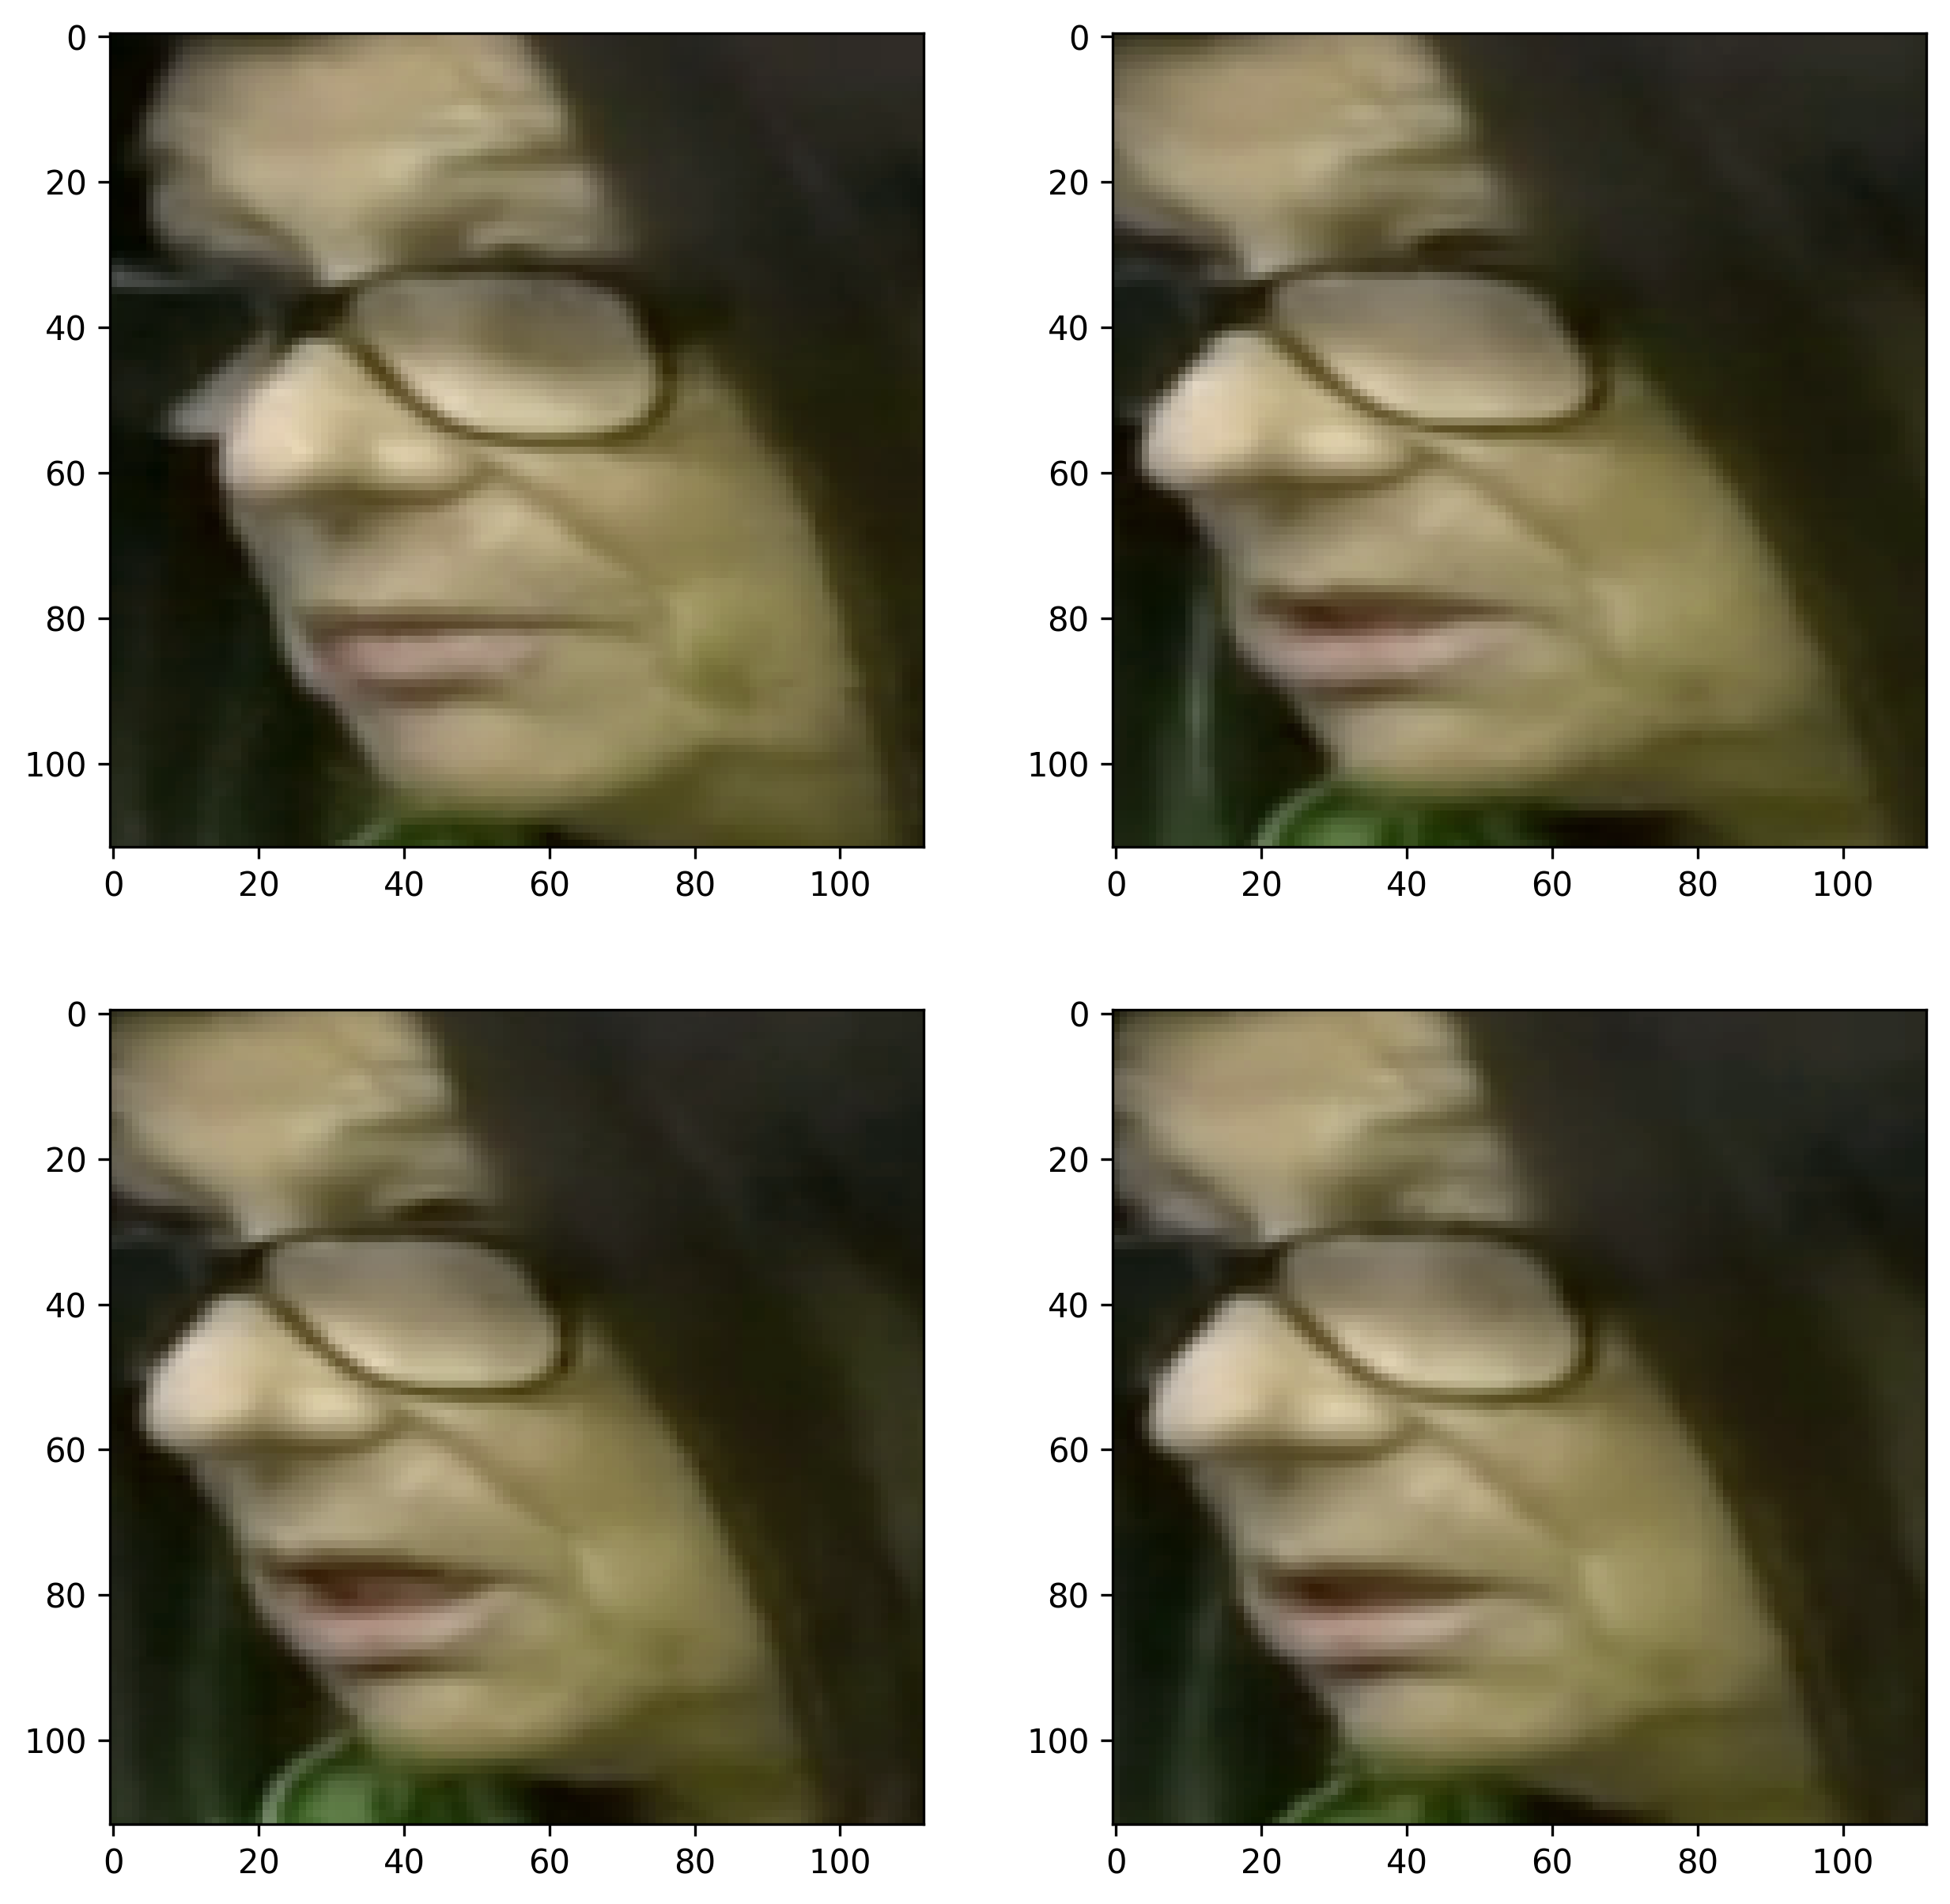

In [69]:
plt.figure(figsize=(10,10))
for ii,img in enumerate(next(iter(train_dataloader))['faces'][0].permute(1, 0, 2, 3)):
    plt.subplot(2,2,ii+1)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = img.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if ii == 3:
        break

In [70]:
next(iter(train_dataloader))['faces'].shape

torch.Size([32, 3, 6, 112, 112])

In [71]:
# next(iter(train_dataloader))['faces'].permute(0, 2, 1, 3, 4).shape

## Models

In [72]:
class DeepfakeClassifierResnet(nn.Module):
    def __init__(self, encoder, in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False, linear_size=2048, num_classes=1):
        super(DeepfakeClassifierResnet, self).__init__()
        self.encoder = encoder
        
        # Modify input layer.
        self.encoder.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=bias,
        )
        
        # Modify output layer.
#         self.encoder.fc = nn.Sequential(
#             nn.BatchNorm1d(linear_size), 
#             nn.Dropout(p=0.25), # 
#             nn.Linear(in_features=linear_size, out_features=2048),
#             nn.ReLU(),
#             nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1),
#             nn.Dropout(p=0.5),
#             nn.Linear(in_features=2048, out_features=num_classes)
#         )
        self.encoder.fc = nn.Linear(linear_size * 1, num_classes)

    def forward(self, x):
        return torch.sigmoid(self.encoder(x))
    
    def freeze_all_layers(self):
        for param in self.encoder.parameters():
            param.requires_grad = False

    def freeze_middle_layers(self):
        self.freeze_all_layers()
        
        for param in self.encoder.conv1.parameters():
            param.requires_grad = True
            
        for param in self.encoder.fc.parameters():
            param.requires_grad = True

    def unfreeze_all_layers(self):
        for param in self.encoder.parameters():
            param.requires_grad = True

In [73]:
class DeepfakeClassifierInception(nn.Module):
    def __init__(self, encoder, in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=3, bias=False, linear_size=512, num_classes=1):
        super(DeepfakeClassifierInception, self).__init__()
        self.encoder = encoder
        
        # Modify input layer.
        self.encoder.conv2d_1a.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=bias,
        )
        
        # Modify output layer.
#         self.encoder.logits = nn.Sequential(
#             nn.BatchNorm1d(linear_size), 
#             nn.Dropout(p=0.25), # 
#             nn.Linear(in_features=linear_size, out_features=2048),
#             nn.ReLU(),
#             nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1),
#             nn.Dropout(p=0.5),
#             nn.Linear(in_features=2048, out_features=num_classes)
#         )
        self.encoder.logits = nn.Linear(linear_size * 1, num_classes)

    def forward(self, x):
        return torch.sigmoid(self.encoder(x))
    
    def freeze_all_layers(self):
        for param in self.encoder.parameters():
            param.requires_grad = False

    def freeze_middle_layers(self):
        self.freeze_all_layers()
        
        for param in self.encoder.conv2d_1a.conv.parameters():
            param.requires_grad = True
            
        for param in self.encoder.logits.parameters():
            param.requires_grad = True

    def unfreeze_all_layers(self):
        for param in self.encoder.parameters():
            param.requires_grad = True

In [74]:
class DeepfakeClassifierR3D18(nn.Module):
    def __init__(self, encoder, linear_size=512, num_classes=1):
        super(DeepfakeClassifierR3D18, self).__init__()
        self.encoder = encoder
        
        # Modify output layer.
        num_features = self.encoder.fc.in_features
        self.encoder.fc = nn.Linear(num_features, num_classes)
#         self.encoder.fc = nn.Sequential(
#             nn.BatchNorm1d(linear_size), 
#             nn.Dropout(p=0.25), # 
#             nn.Linear(in_features=linear_size, out_features=2048),
#             nn.ReLU(),
#             nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1),
#             nn.Dropout(p=0.5),
#             nn.Linear(in_features=2048, out_features=num_classes)
#         )

#         self.encoder.logits = nn.Linear(linear_size * 1, num_classes)

    def forward(self, x):
        return torch.sigmoid(self.encoder(x))
    
    def freeze_all_layers(self):
        for param in self.encoder.parameters():
            param.requires_grad = False

    def freeze_middle_layers(self):
        self.freeze_all_layers()
            
        for param in self.encoder.fc.parameters():
            param.requires_grad = True

    def unfreeze_all_layers(self):
        for param in self.encoder.parameters():
            param.requires_grad = True

In [75]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, sample_weight=None):
        super().__init__()
        self.gamma = gamma
        self.sample_weight = sample_weight

    def forward(self, logit, target):
        target = target.float()
        max_val = (-logit).clamp(min=0)
        loss = logit - logit * target + max_val + \
               ((-max_val).exp() + (-logit - max_val).exp()).log()

        invprobs = F.logsigmoid(-logit * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        if len(loss.size())==2:
            loss = loss.sum(dim=1)
        if self.sample_weight is not None:
            loss = loss * self.sample_weight
        return loss.mean()

In [76]:
# efficient_transformer = Linformer(
#     dim=128,
#     seq_len=49+1,  # 7x7 patches + 1 cls-token
#     depth=12,
#     heads=8,
#     k=64
# )

# classifier = ViT(
#     dim=128,
#     image_size=224,
#     patch_size=32,
#     num_classes=1,
#     transformer=efficient_transformer,
#     channels=3,
# ).to(device)
# classifier.train()

In [77]:
encoder_r3d_18 = models.video.r3d_18(
    pretrained=True,
)

classifier = DeepfakeClassifierR3D18(encoder=encoder_r3d_18, linear_size=512, num_classes=1)

classifier.to(device);
classifier.train();

In [78]:
# x = torch.zeros(1, 3, N_FACES, H, W)
# y= classifier(x)
# print(y.shape)

In [79]:
# encoder_facenet = InceptionResnetV1(
#     classify=True,
#     pretrained='casia-webface',
#     num_classes=1
# )

# classifier = DeepfakeClassifierInception(encoder=encoder_facenet, in_channels=3*N_FACES, num_classes=1)

# classifier.to(device);
# classifier.train();

In [80]:
# encoder_resnet = resnet101(pretrained=True)

# classifier = DeepfakeClassifierResnet(encoder=encoder_resnet, in_channels=3*N_FACES, num_classes=1)

# classifier.to(device);
# classifier.train();

In [81]:
criterion = nn.BCELoss()#FocalLoss()

In [82]:
losses = np.zeros(WARM_UP_EPOCHS + FINE_TUNE_EPOCHS)
val_losses = np.zeros(WARM_UP_EPOCHS + FINE_TUNE_EPOCHS)
f1_scores = np.zeros(WARM_UP_EPOCHS + FINE_TUNE_EPOCHS)
val_f1_scores = np.zeros(WARM_UP_EPOCHS + FINE_TUNE_EPOCHS)

best_val_loss = 1e7

## Define training hyperparameters

In [83]:
classifier.freeze_middle_layers()
warmup_optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=WARM_UP_LR)
warmup_scheduler = ReduceLROnPlateau(warmup_optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, threshold_mode='abs', verbose=True)

In [84]:
summary(classifier, input_size=(3, N_FACES, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 64, 6, 56, 56]          28,224
       BatchNorm3d-2        [-1, 64, 6, 56, 56]             128
              ReLU-3        [-1, 64, 6, 56, 56]               0
      Conv3DSimple-4        [-1, 64, 6, 56, 56]         110,592
       BatchNorm3d-5        [-1, 64, 6, 56, 56]             128
              ReLU-6        [-1, 64, 6, 56, 56]               0
      Conv3DSimple-7        [-1, 64, 6, 56, 56]         110,592
       BatchNorm3d-8        [-1, 64, 6, 56, 56]             128
              ReLU-9        [-1, 64, 6, 56, 56]               0
       BasicBlock-10        [-1, 64, 6, 56, 56]               0
     Conv3DSimple-11        [-1, 64, 6, 56, 56]         110,592
      BatchNorm3d-12        [-1, 64, 6, 56, 56]             128
             ReLU-13        [-1, 64, 6, 56, 56]               0
     Conv3DSimple-14        [-1, 64, 6,

In [85]:
# WARM_UP_LR

## Training

In [86]:
losses[:WARM_UP_EPOCHS], val_losses[:WARM_UP_EPOCHS], \
f1_scores[:WARM_UP_EPOCHS], val_f1_scores[:WARM_UP_EPOCHS], \
best_val_loss, \
best_model_state_dict, best_optimizer_state_dict \
= train_the_model(
    model=classifier,
    criterion=criterion,
    optimizer=warmup_optimizer,
    scheduler=warmup_scheduler,
    epochs=WARM_UP_EPOCHS,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    best_val_loss=best_val_loss,
)

# Save the best checkpoint.
if best_model_state_dict is not None:
    state = {
        'state_dict': best_model_state_dict,
        'warmup_optimizer': best_optimizer_state_dict,
        'best_val_loss': best_val_loss,
    }
    torch.save(state, 'best-checkout-warmup.pth')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.6080679952634448 | val loss: 0.5835685888810676 | f1: 0.6773163910505836 | val f1: 0.6954407294832827
Found a better checkpoint!


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.597644759494275 | val loss: 0.5547055150418319 | f1: 0.6875 | val f1: 0.7137993920972644
Found a better checkpoint!


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.592075538687437 | val loss: 0.5475409926139108 | f1: 0.6895367217898832 | val f1: 0.7251063829787234
Found a better checkpoint!


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.5932631679604026 | val loss: 0.5520850424329902 | f1: 0.6898407101167315 | val f1: 0.7179331306990883


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.5930137895192618 | val loss: 0.6332532325687334 | f1: 0.6909350680933852 | val f1: 0.6871732522796352


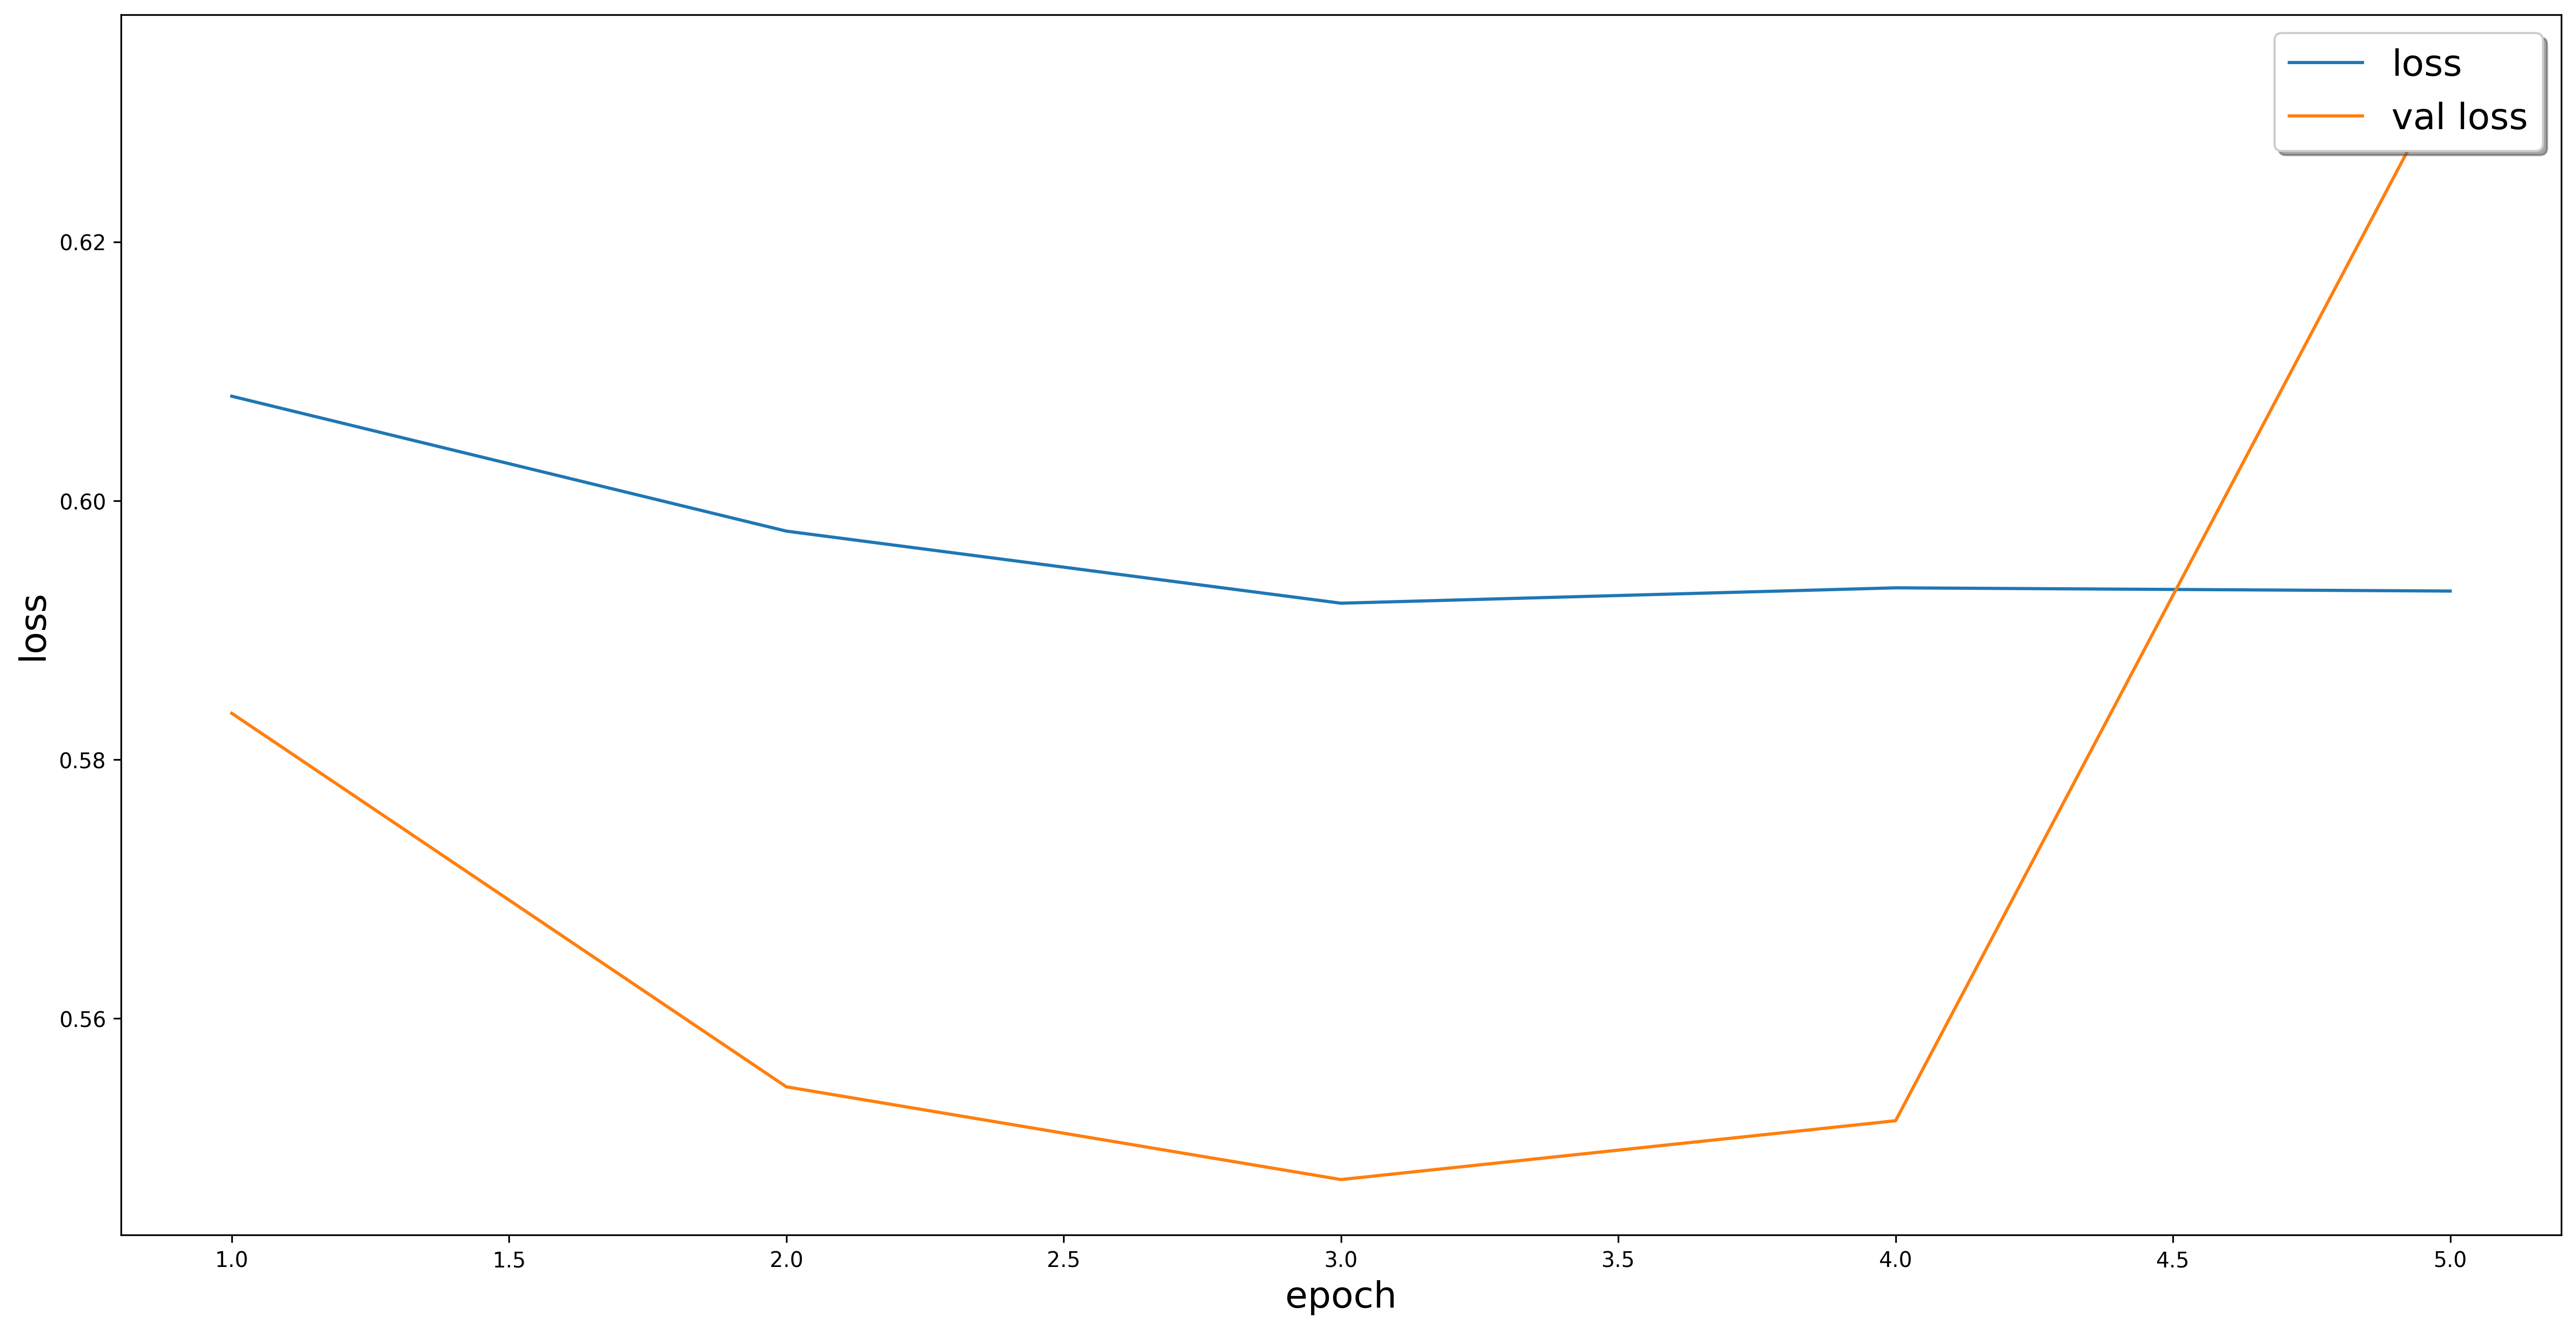

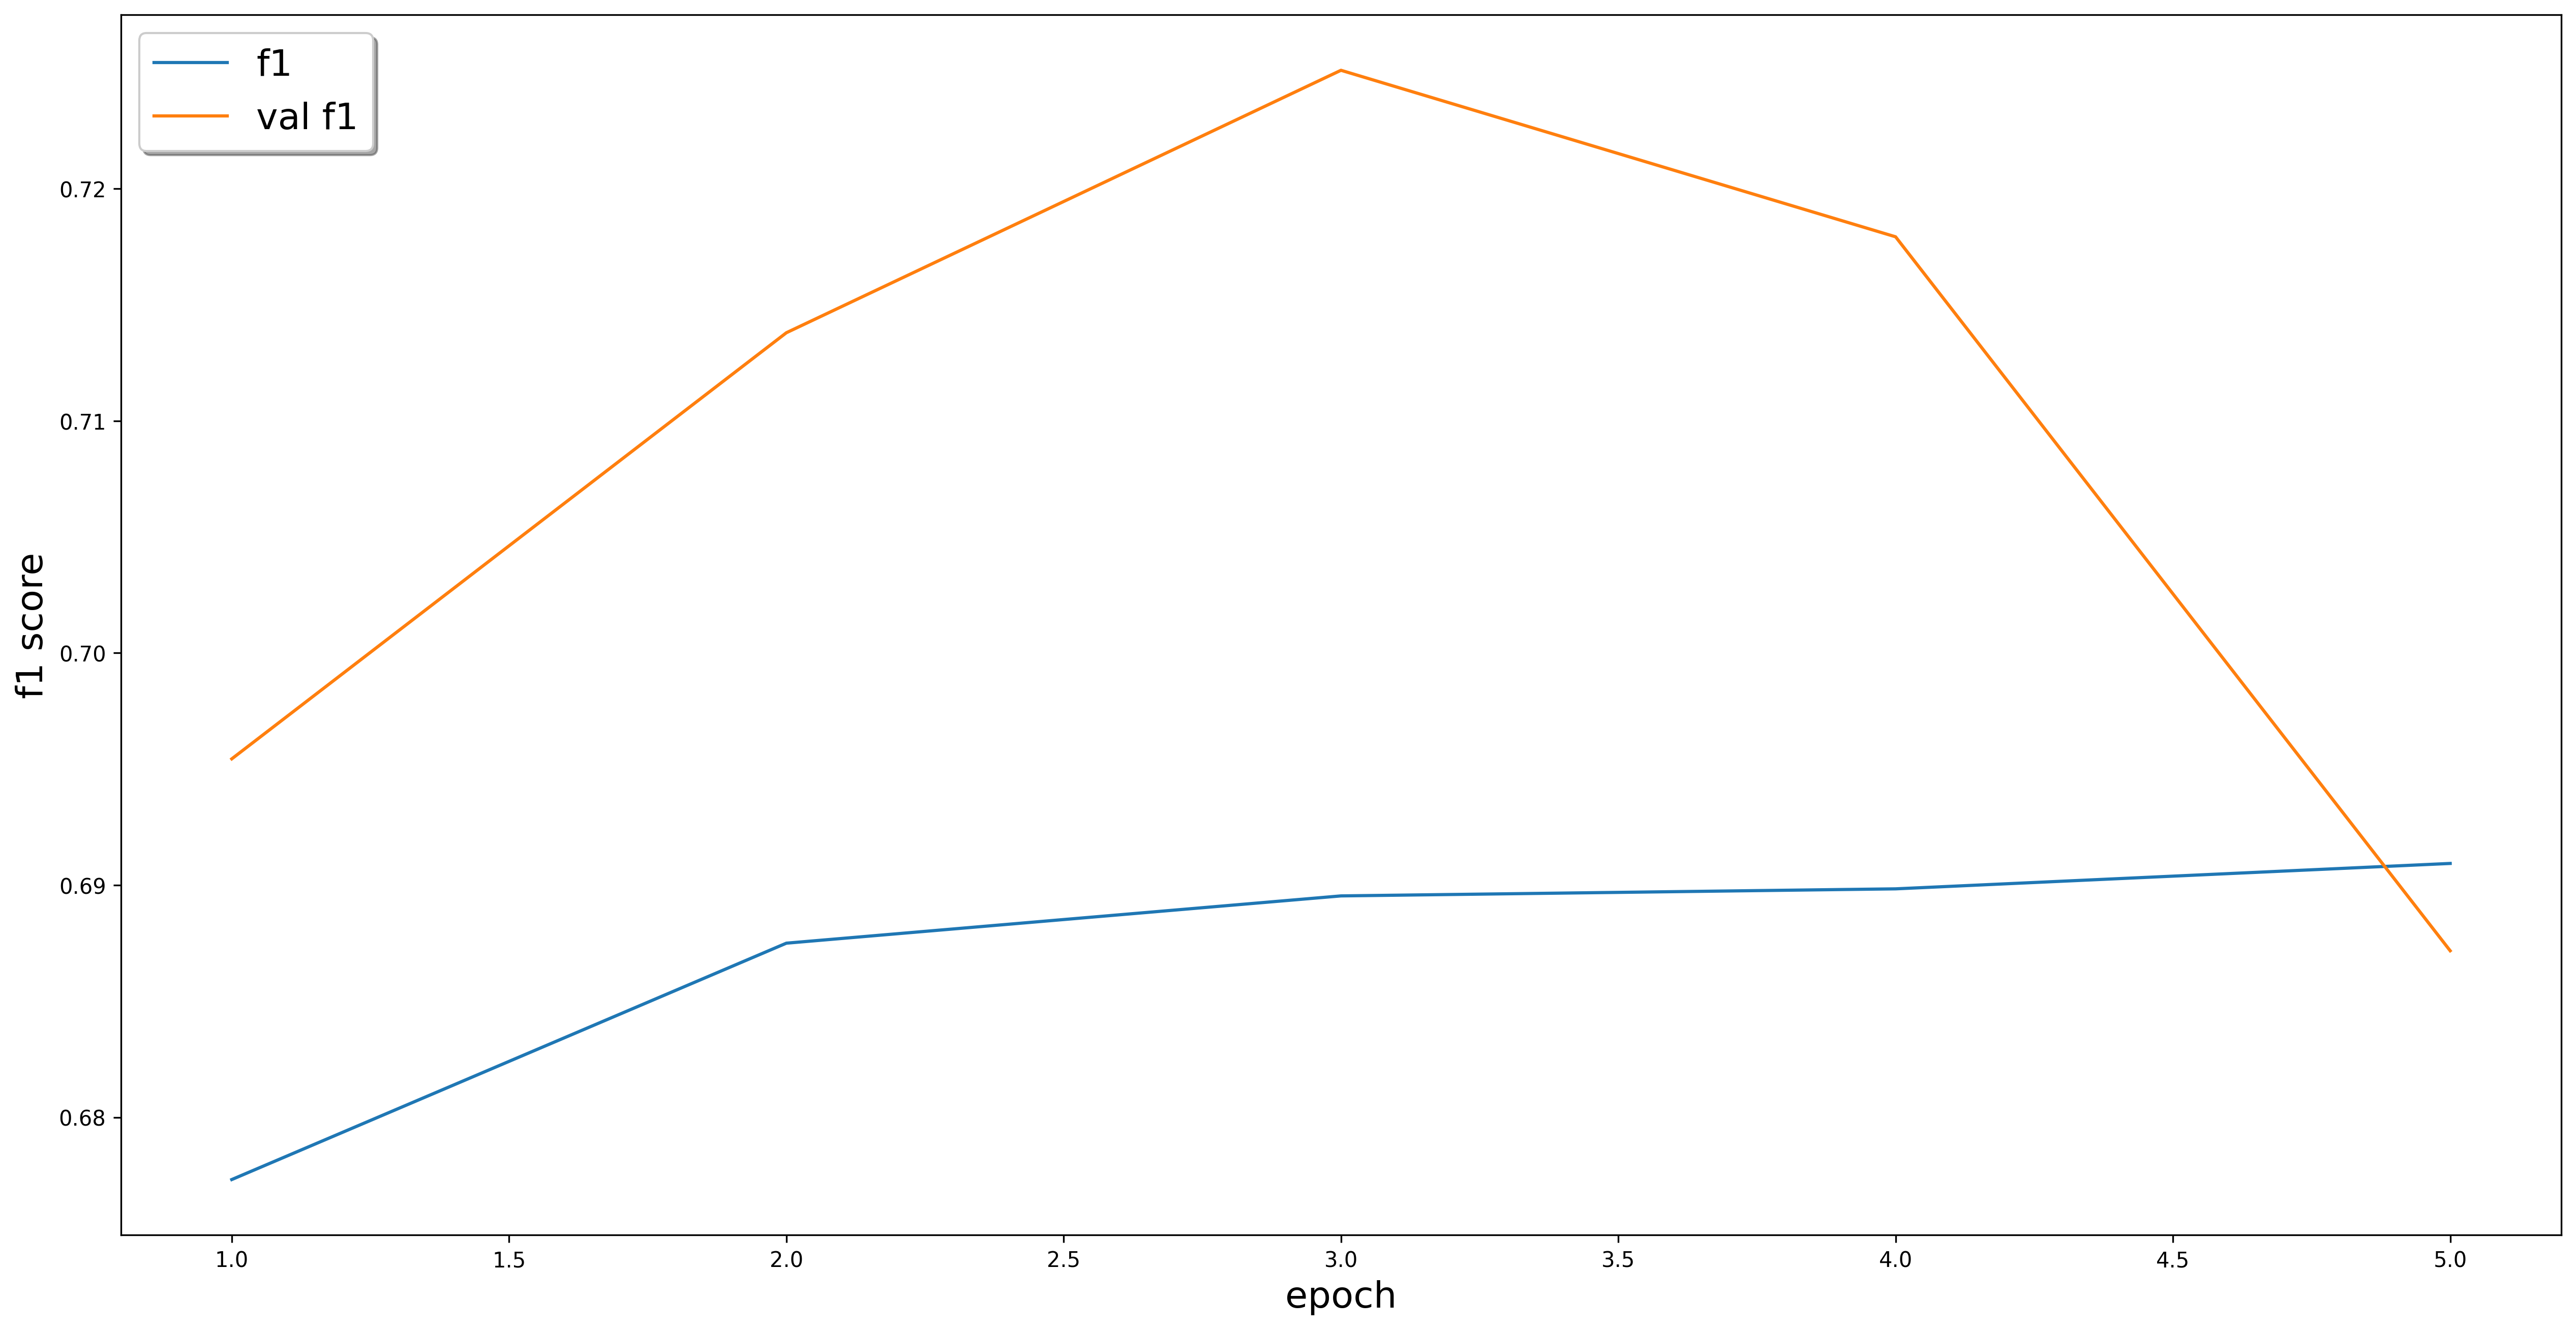

In [87]:
visualize_results(
    losses=losses[:WARM_UP_EPOCHS],
    val_losses=val_losses[:WARM_UP_EPOCHS],
    f1_scores=f1_scores[:WARM_UP_EPOCHS],
    val_f1_scores=val_f1_scores[:WARM_UP_EPOCHS]
)

In [88]:
# state = torch.load(PATH2PROJECT / 'trainreface' / 'temp-best-checkout-resnet101.pth', map_location=lambda storage, loc: storage)
state = torch.load('best-checkout-warmup.pth', map_location=lambda storage, loc: storage)
# state = torch.load('best-checkout.pth', map_location=lambda storage, loc: storage)
best_val_loss = state['best_val_loss']
classifier.load_state_dict(state['state_dict'])
# classifier.to(device)

<All keys matched successfully>

In [89]:
classifier.unfreeze_all_layers()
finetune_optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=FINE_TUNE_LR)
finetune_scheduler = ReduceLROnPlateau(finetune_optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, threshold_mode='abs', verbose=True)

In [90]:
# FINE_TUNE_LR

In [91]:
# losses[WARM_UP_EPOCHS:WARM_UP_EPOCHS+FINE_TUNE_EPOCHS], val_losses[WARM_UP_EPOCHS:WARM_UP_EPOCHS+FINE_TUNE_EPOCHS], \
# f1_scores[WARM_UP_EPOCHS:WARM_UP_EPOCHS+FINE_TUNE_EPOCHS], val_f1_scores[WARM_UP_EPOCHS:WARM_UP_EPOCHS+FINE_TUNE_EPOCHS], \
# best_val_loss, best_val_logloss, \
# best_model_state_dict, best_optimizer_state_dict \
_, _, \
_, _, \
best_val_loss, \
best_model_state_dict, best_optimizer_state_dict \
= train_the_model(
    model=classifier,
    criterion=criterion,
    optimizer=finetune_optimizer,
    scheduler=finetune_scheduler,
    epochs=FINE_TUNE_EPOCHS,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    best_val_loss=best_val_loss,
)

# Save the best checkpoint.
if best_model_state_dict is not None:
    state = {
        'state_dict': best_model_state_dict,
        'finetune_optimizer': best_optimizer_state_dict,
        'best_val_loss': best_val_loss,
    }

    torch.save(state, 'best-checkout-finetune.pth')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.4949396377871473 | val loss: 0.976454612243083 | f1: 0.7612171692607003 | val f1: 0.5804255319148937


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.3611180244325316 | val loss: 0.3158019200660462 | f1: 0.837153453307393 | val f1: 0.8696656534954408
Found a better checkpoint!


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.3108754902280838 | val loss: 0.23350259595254594 | f1: 0.8686466439688716 | val f1: 0.9061398176291793
Found a better checkpoint!


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.2788559923723978 | val loss: 0.1723403397860915 | f1: 0.882295719844358 | val f1: 0.9325227963525836
Found a better checkpoint!


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.25843139145711747 | val loss: 0.18909615067433017 | f1: 0.8913849708171206 | val f1: 0.9240121580547113


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.2441351163429335 | val loss: 0.17559928511984127 | f1: 0.8988630836575877 | val f1: 0.931306990881459


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.22689031683459357 | val loss: 0.17703513107388893 | f1: 0.9068275778210116 | val f1: 0.9311854103343465


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.21554969301164614 | val loss: 0.31339225993137954 | f1: 0.9118433852140078 | val f1: 0.8689361702127659


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.20057910227430586 | val loss: 0.16098786423762523 | f1: 0.9193518968871596 | val f1: 0.9354407294832827
Found a better checkpoint!


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.19119853173755835 | val loss: 0.1507762093169167 | f1: 0.9230605544747081 | val f1: 0.9418844984802431
Found a better checkpoint!


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.18404235578493616 | val loss: 0.1307568906828068 | f1: 0.926039640077821 | val f1: 0.9525835866261398
Found a better checkpoint!


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.17257119345764996 | val loss: 0.16928535881416165 | f1: 0.9300826848249028 | val f1: 0.9343465045592705


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.16810174103362435 | val loss: 0.1435557665554229 | f1: 0.9330009727626459 | val f1: 0.9450455927051672


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.16224973337318938 | val loss: 0.17565543280712279 | f1: 0.9344905155642024 | val f1: 0.931063829787234


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.1570426228706243 | val loss: 0.14413148704433432 | f1: 0.9377127918287937 | val f1: 0.945531914893617


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.15028273641831216 | val loss: 0.1480234576851245 | f1: 0.9417558365758755 | val f1: 0.9418844984802431


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.1432899129721934 | val loss: 0.13324951220939094 | f1: 0.9441877431906615 | val f1: 0.9500303951367781
Epoch    17: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.10206191840849758 | val loss: 0.09440930663470844 | f1: 0.9608463035019456 | val f1: 0.9657142857142856
Found a better checkpoint!


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.08566877255483497 | val loss: 0.09462080528786362 | f1: 0.9686588035019456 | val f1: 0.9680243161094225


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss: 0.08124265275806812 | val loss: 0.09047357170831759 | f1: 0.9703307392996109 | val f1: 0.969726443768997
Found a better checkpoint!


In [92]:
# state = torch.load(PATH2PROJECT / 'trainreface' / 'temp-best-checkout-resnet101.pth', map_location=lambda storage, loc: storage)
state = torch.load('best-checkout-finetune.pth', map_location=lambda storage, loc: storage)
# state = torch.load('best-checkout.pth', map_location=lambda storage, loc: storage)
best_val_loss = state['best_val_loss']
classifier.load_state_dict(state['state_dict'])
# classifier.to(device)

<All keys matched successfully>

In [93]:
# from IPython.display import FileLink
# FileLink('best-checkout.pth')

In [94]:
# visualize_results(
#     losses=losses,
#     val_losses=val_losses,
#     loglosses=loglosses,
#     val_loglosses=val_loglosses,
#     f1_scores=f1_scores,
#     val_f1_scores=val_f1_scores
# )

## Inference and submission

In [95]:
def inference(classifier, test_dataloader):
    classifier.eval()
    
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for _, batch in enumerate(tqdm(test_dataloader, total=len(test_dataloader))):
            # Make prediction.
            y_pred = classifier(batch['faces'].to(device))

            all_preds.extend(y_pred.squeeze(dim=-1).detach().cpu().numpy().tolist())
            all_labels.extend(batch['label'].squeeze(dim=-1).numpy().tolist())
    return all_preds, all_labels

In [96]:
test_prediction, _ = inference(classifier, test_dataloader)
len(test_prediction)

  0%|          | 0/556 [00:00<?, ?it/s]

17791

In [97]:
val_prediction, val_labels = inference(classifier, val_dataloader)
len(val_prediction)

  0%|          | 0/258 [00:00<?, ?it/s]

8225

In [98]:
X_test['score'] = test_prediction

In [99]:
thresholds = np.linspace(0, 1, len(np.unique(val_prediction)))
f1_scores = [f1_score(val_labels, (np.array(val_prediction) > t).astype(np.uint8), average='micro') for t in tqdm(thresholds)]
t_best = thresholds[np.argmax(f1_scores)]
print('Best threshold: ', t_best)
print('Best F1-Score: ', np.max(f1_scores))

  0%|          | 0/7564 [00:00<?, ?it/s]

Best threshold:  0.614438714795716
Best F1-Score:  0.969726443768997


In [100]:
from IPython.display import FileLink

In [101]:
X_test['label'] = (X_test['score'] > t_best).astype(int)
submission_result = submission[['filename', 'path']].merge(X_test[['path', 'label']], on='path', how='left').fillna(0)[['filename', 'label']]
submission_result['label'] = submission_result['label'].astype(int)

assert submission_result.shape[0] == submission.shape[0]

submission_result.to_csv('submission_result_th.csv', index=False)

FileLink('submission_result_th.csv')

/content/submission_result_th.csv

In [102]:
X_test['label'] = (X_test['score'] > 0.5).astype(int)
submission_result = submission[['filename', 'path']].merge(X_test[['path', 'label']], on='path', how='left').fillna(0)[['filename', 'label']]
submission_result['label'] = submission_result['label'].astype(int)

assert submission_result.shape[0] == submission.shape[0]

submission_result.to_csv('submission_result_05.csv', index=False)

FileLink('submission_result_05.csv')

/content/submission_result_05.csv

In [103]:
!cp submission_result_th.csv /content/drive/MyDrive/dl-creator-school/submission_result_th.csv

In [104]:
!cp submission_result_05.csv /content/drive/MyDrive/dl-creator-school/submission_result_05.csv

In [105]:
!cp best-checkout-finetune.pth /content/drive/MyDrive/dl-creator-school/best-checkout-finetune.pth